
Dataset and competition for search relevance:

https://www.kaggle.com/c/crowdflower-search-relevance

In [1]:
import pandas as pd

df = pd.read_csv('data/crowdflower-search-relevance.csv', index_col=0)

In [2]:
df.shape

(10158, 5)

In [36]:
df.head()

,query,product_title,product_description,median_relevance,relevance_variance,product_title_and_description,query_tfidf,product_title_and_description_tfidf,query_lsi,product_title_and_description_lsi,distance_tfidf,distance_lsi
id,,,,,,,,,,,,
1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000,Accent Pillow with Heart Design - Red/Black Re...,"[0.67008, 0.42095277, 0.6113849, 0.0, 0.0, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.02180974, 0.049421445, -0.02118985, -0.002...","[-0.07893277, 0.19300768, -0.10535035, -0.0281...",1.000000,1.004718
2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000,Set of 10 Battery Operated Multi LED Train Chr...,"[0.0, 0.0, 0.0, 0.7136383, 0.5487598, 0.435411...","[0.0, 0.0, 0.0, 0.16900037, 0.19493197, 0.3093...","[-0.02691677, 0.029319795, 0.022957109, 0.0302...","[-0.112073116, 0.11561964, 0.074471526, 0.1149...",0.637736,0.432910
5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000,Concept Housewares WR-44526 Solid-Wood Ceiling...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63814485, 0.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39997026, 0.0...","[-0.016031532, 0.021653702, 0.016151018, 0.022...","[-0.05600504, 0.064555354, 0.048362166, 0.0477...",0.670455,0.384528
7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471,Wintergreen Lighting Christmas LED Light Bulb ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5853502, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.2346195, 0.18041319, 0.28629...","[-0.03293611, 0.036437854, 0.028536426, 0.0380...","[-0.047095515, 0.050624378, 0.035381578, 0.046...",0.430518,0.076438
8,oakley polarized radar,Oakley Sunglasses - Radar Path Polished Black/...,"Durability and all-day comfort of lightweight,...",3,1.166,Oakley Sunglasses - Radar Path Polished Black/...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.09897827, 0.0, 0.0...","[-0.0070212414, 0.008407454, 0.005639437, 0.01...","[-0.07500987, 0.07832663, 0.03937703, 0.072293...",0.740079,0.302889


In [5]:
df.fillna('', inplace=True)

In [6]:
def concatenate_title_and_description(row):
    return row['product_title'] + ' ' + row['product_description']

df['product_title_and_description'] = df.apply(concatenate_title_and_description, axis=1)

In [19]:
from gensim.parsing.preprocessing import preprocess_documents

query_texts = preprocess_documents(df['query'])
product_title_and_description_texts = preprocess_documents(df['product_title_and_description'])

In [10]:
query_corpus[0][:3]

['bridal', 'shower', 'decor']

In [12]:
from gensim.corpora import Dictionary

dictionary = Dictionary(all_corpus)

In [13]:
len(dictionary)

17676

In [14]:
dictionary.filter_extremes(no_below=5, no_above=0.2)

In [15]:
len(dictionary)

5591

In [20]:
query_corpus = [dictionary.doc2bow(x) for x in query_texts]
product_title_and_description_corpus = [dictionary.doc2bow(x) for x in product_title_and_description_texts]

all_corpus = query_corpus + product_title_and_description_corpus

In [16]:
tfidf_dimensions = len(dictionary)
lsi_dimensions = 150

In [21]:
from gensim.models import TfidfModel

tfidf = TfidfModel(all_corpus, id2word=dictionary)

query_tfidf = tfidf[query_corpus]
product_title_and_description_tfidf = tfidf[product_title_and_description_corpus]
all_tfidf = tfidf[all_corpus]

In [22]:
from gensim.models import LsiModel

lsi = LsiModel(all_tfidf, id2word=dictionary)

query_lsi = lsi[query_tfidf]
product_title_and_description_lsi = lsi[product_title_and_description_tfidf]
all_lsi = lsi[all_tfidf]

In [24]:
from gensim.matutils import sparse2full

df['query_tfidf'] = [sparse2full(x, tfidf_dimensions) for x in query_tfidf]
df['product_title_and_description_tfidf'] = [sparse2full(x, tfidf_dimensions) for x in product_title_and_description_tfidf]

df['query_lsi'] = [sparse2full(x, tfidf_dimensions) for x in query_lsi]
df['product_title_and_description_lsi'] = [sparse2full(x, tfidf_dimensions) for x in product_title_and_description_lsi]

In [28]:
from scipy.spatial.distance import cosine

def cosine_distance_tfidf(row):
    return cosine(row['query_tfidf'], row['product_title_and_description_tfidf'])

def cosine_distance_lsi(row):
    return cosine(row['query_lsi'], row['product_title_and_description_lsi'])

df['distance_tfidf'] = df.apply(cosine_distance_tfidf, axis=1)
df['distance_lsi'] = df.apply(cosine_distance_lsi, axis=1)

/home/dehling/Documents/machine-learnings/lib/python3.5/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [29]:
# df[['query', 'product_title_and_desription', 'median_relevance', 'dist']].sort_values(by=['dist']).head(n=10)

In [30]:
df['median_relevance'].corr(df['distance_tfidf'])

-0.3668918343245772

In [31]:
df['median_relevance'].corr(df['distance_lsi'])

-0.3587136456709309

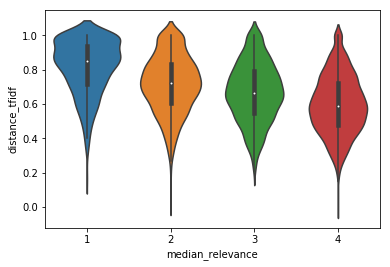

In [32]:
import seaborn as sns
%matplotlib inline

sns.violinplot(x='median_relevance', y='distance_tfidf', data=df)

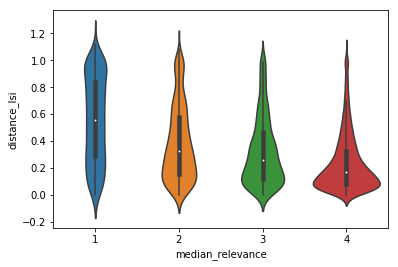

In [33]:
sns.violinplot(x='median_relevance', y='distance_lsi', data=df)

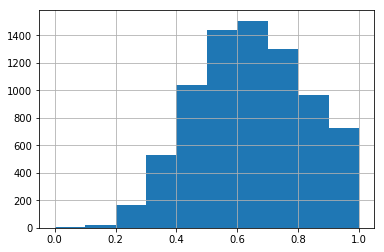

In [34]:
df['distance_tfidf'].hist()

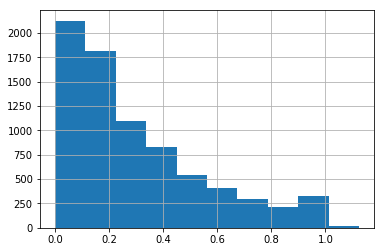

In [35]:
df['distance_lsi'].hist()